In [140]:
# Importing data. Regions: M <- Mountain, MET <- Metropolitan, SEC <- Southeast Coastal
# Products: sp <- special, lo <- low, hi <- high
library(readr)
Bev_data <- read_csv("C:/Users/Dell/Desktop/Bev.csv")
head(Bev_data)

Parsed with column specification:
cols(
  M.hi.p = col_double(),
  M.lo.p = col_double(),
  MET.hi.p = col_double(),
  MET.lo.p = col_double(),
  MET.sp.p = col_double(),
  SEC.hi.p = col_double(),
  SEC.lo.p = col_double(),
  M.hi = col_double(),
  M.lo = col_double(),
  MET.hi = col_double(),
  MET.lo = col_double(),
  MET.sp = col_double(),
  SEC.hi = col_double(),
  SEC.lo = col_double()
)


M.hi.p,M.lo.p,MET.hi.p,MET.lo.p,MET.sp.p,SEC.hi.p,SEC.lo.p,M.hi,M.lo,MET.hi,MET.lo,MET.sp,SEC.hi,SEC.lo
59.25,29.19,63.67,26.03,50.09,58.56,29.19,458,1455,2037,3437,468,156,544
56.26,26.31,60.34,25.54,48.82,54.64,26.31,477,1756,1700,3436,464,151,624
56.26,26.25,60.79,25.69,48.56,57.90,26.25,539,2296,1747,3304,490,178,611
49.33,26.15,55.09,26.46,47.74,49.70,26.15,687,3240,2371,3864,657,217,646
61.34,25.88,65.09,25.72,50.75,63.72,25.88,389,2252,1741,3406,439,141,624
61.40,27.35,67.91,26.17,52.63,68.38,27.35,399,1901,2072,3418,453,149,610


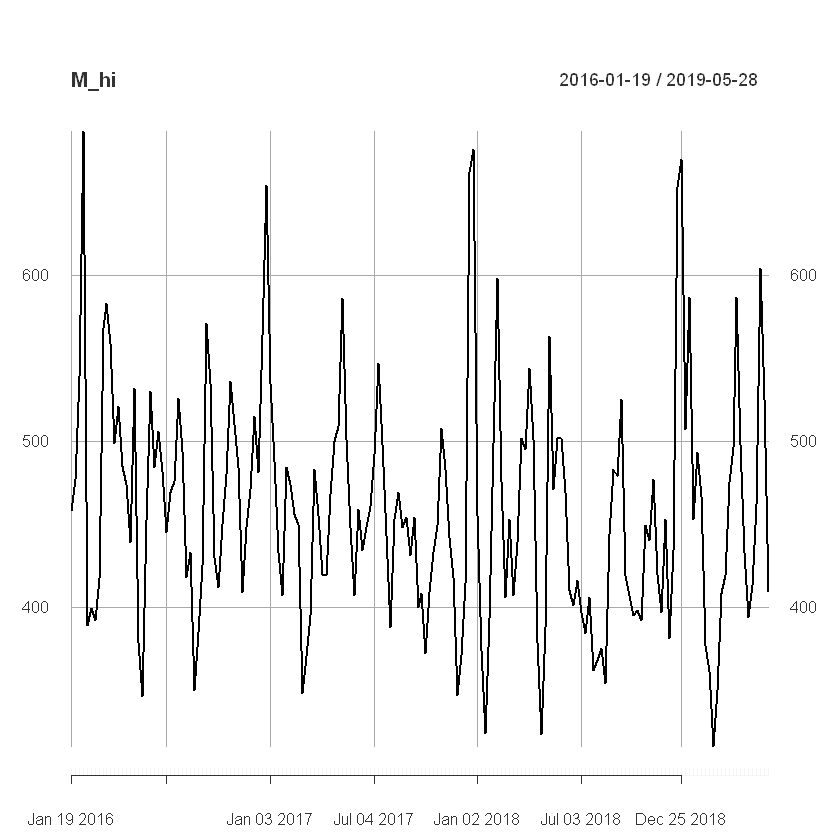

In [141]:
# Creating a date index object, starting 2016-01-19
# Creating an xts (extensible time series) object with xts library
dates <- seq(as.Date("2016-01-19"), length = 176, by = "weeks")
library(xts)
Bev_xts <- xts(Bev_data, order.by = dates)

# Plot of Mountain Region Hi Product
library(stats)
M_hi <- Bev_xts[,"M.hi"]
plot(M_hi)

In [142]:
# Train / Test split of data for Mountain Region
M_total <- Bev_xts[,"M.hi"] + Bev_xts[,"M.lo"]

# Assigning 2019 period for Test Data
M_total_train <- M_total[index(M_total) < "2019-01-01"]
M_total_test <- M_total[index(M_total) >= "2019-01-01"]


In [145]:
# Building ARIMA model upon training data
install.packages("forecast")
library(forecast)

M_t_model <- auto.arima(M_total_train)
summary(M_t_model)

Installing package into 'C:/Users/Dell/Documents/R/win-library/3.6'
(as 'lib' is unspecified)



  There is a binary version available but the source version is later:
         binary source needs_compilation
forecast   8.11   8.12              TRUE

  Binaries will be installed


Warning message:
"package 'forecast' is in use and will not be installed"

Series: M_total_train 
ARIMA(5,0,0) with non-zero mean 

Coefficients:
         ar1      ar2     ar3     ar4     ar5       mean
      0.6960  -0.1536  0.0827  0.0284  0.0863  2031.7870
s.e.  0.0809   0.1002  0.1023  0.1173  0.0990    77.2781

sigma^2 estimated as 67773:  log likelihood=-1072.35
AIC=2158.71   AICc=2159.47   BIC=2179.96

Training set error measures:
                    ME     RMSE      MAE       MPE     MAPE       MASE
Training set -2.303076 255.2106 178.2267 -1.510674 8.681943 0.08830512
                     ACF1
Training set -0.001241849


In [146]:
# Building a forecast based on training data within a 22 weeks period
forecast_M_t <- forecast(M_t_model, h = 22)

# xts object of the forecast
for_dates <- seq(as.Date("2019-01-01"), length = 22, by = "weeks")
for_M_t_xts <- xts(forecast_M_t$mean, order.by = for_dates)


In [147]:
# Measuring accuracy of the Time-series forecast
for_M_t <- as.numeric(forecast_M_t$mean)
v_M_t <- as.numeric(M_total_test)

# MAE = Mean Absolute Error ; MAPE = Mean Absolute Percentage Error
MAE <- mean(abs(for_M_t - v_M_t))
MAPE <- 100 * mean(abs((for_M_t - v_M_t)/v_M_t))

print(MAE)
print(MAPE)

[1] 208.152
[1] 10.06563


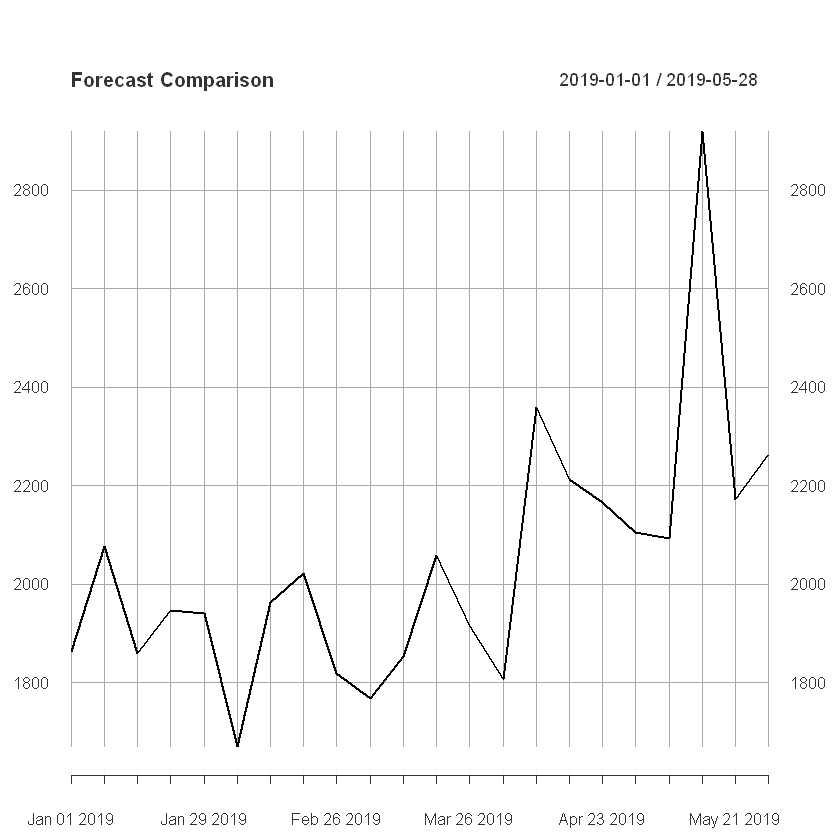

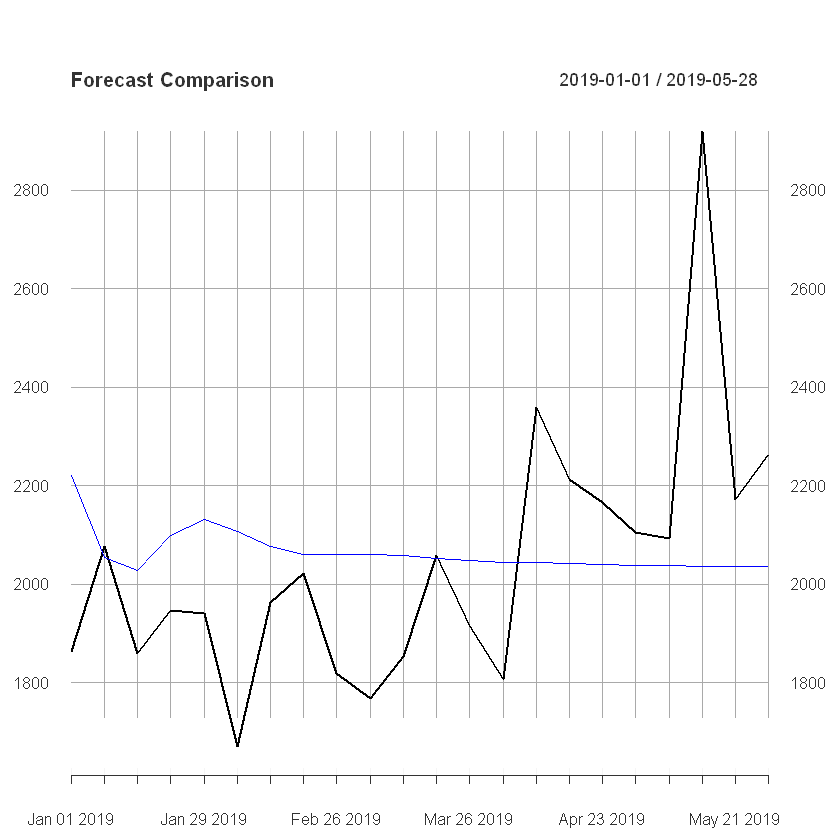

In [148]:
# We are off by around 10.06% on avg.
# Checking confidence intervals, converting upper&lower limits to xts object
lower <- xts(forecast_M_t$lower[,2], order.by = for_dates)
upper <- xts(forecast_M_t$upper[,2], order.by = for_dates)

plot(M_total_test, main="Forecast Comparison")
lines(for_M_t_xts, col = "blue")

In [149]:
# Price Elasticity Analysis with Linear Regression
# Creating seperate "sales" and "price" vectors
M_hi_sales <- as.vector(Bev_xts[,"M.hi"])
M_hi_price <- as.vector(Bev_xts[,"M.hi.p"])

# Storing the logs into a data frame
M_hi_train <- data.frame(log(M_hi_sales), log(M_hi_price))
colnames(M_hi_train) <- c("log_sales", "log_price")

model_M_hi <- lm(log_sales ~ log_price, data= M_hi_train)
model_M_hi
# abs(log_price) = 0.70 -> This means the product is "inelastic"


Call:
lm(formula = log_sales ~ log_price, data = M_hi_train)

Coefficients:
(Intercept)    log_price  
     8.9453      -0.7016  


In [150]:
# Adding Seasonality data (Valentines Day)
# Creating a binary data field
v_dates <- as.Date(c("2016-02-09", "2016-02-08", "2016-02-07"))
v_xts <- as.xts(rep(1,3), order.by = v_dates)

dates_train <- seq(as.Date("2016-01-19"), length = 174, by="weeks")
v_merge <- merge(v_xts, dates_train, fill=0)

head(v_merge, n=5)

           v_xts
2016-01-19     0
2016-01-26     0
2016-02-02     0
2016-02-07     1
2016-02-08     1

In [151]:
# Adding Seasonality Effect to the Regression Model
M_hi_train <- data.frame(M_hi_train, as.vector(v_merge))
model_M_hi_full <- lm(log_sales ~ log_price + v_merge, data = M_hi_train)

summary(model_M_hi_full)


Call:
lm(formula = log_sales ~ log_price + v_merge, data = M_hi_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.32811 -0.08924 -0.01066  0.08522  0.41655 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  8.95042    0.45403  19.713  < 2e-16 ***
log_price   -0.70315    0.11262  -6.243 3.21e-09 ***
v_merge      0.05483    0.07987   0.686    0.493    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1371 on 173 degrees of freedom
Multiple R-squared:  0.1851,	Adjusted R-squared:  0.1757 
F-statistic: 19.65 on 2 and 173 DF,  p-value: 2.042e-08


In [152]:
# Filling the binary 1 and 0 to the field and merge
library(xts)

v_dates_test <- as.Date("2019-02-12")
v_xts_test <- as.xts(1, order.by = v_dates_test)

dates_test <- seq(as.Date("2019-01-01"), length = 22, by = "weeks")
v_xts_v <- merge(v_xts_test, dates_test, fill = 0)

In [153]:
# Taking log and building data frame
log_M_hi_p_test <- log(Bev_xts[,"M.hi.p"])
model_M_test <- data.frame(as.vector(log_M_hi_p_test), as.vector(v_xts_v))
colnames(model_M_test) <- c("log_price", "valentine")

head(model_M_test,n=8)

log_price,valentine
4.081766,0
4.029984,0
4.029984,0
3.898532,0
4.116432,0
4.117410,0
4.187076,1
4.099995,0


In [154]:
# Prediction on the test data object "model_M_test"
pred_M_hi <- predict(model_M_hi_full, model_M_test)
head(pred_M_hi)

1        2        3        4        5        6 
6.080330 6.116740 6.116740 6.263998 6.110782 6.110095

In [155]:
# Reverse log outputs
pred_M_hi <- exp(pred_M_hi)
head(pred_M_hi)

1        2        3        4        5        6 
437.1734 453.3844 453.3844 525.3151 450.6911 450.3814

In [156]:
# Preparing residuals og the regression model for ARIMA model
M_hi_full_res <- residuals(model_M_hi_full)
M_hi_full_res <- xts(M_hi_full_res, order.by = dates)
head(M_hi_full_res)

                  [,1]
2016-01-19  0.04653930
2016-01-26  0.05077613
2016-02-02  0.17297521
2016-02-09  0.26833606
2016-02-16 -0.14720279
2016-02-23 -0.12113327

In [157]:
# ARIMA on residuals
M_hi_Arima <- auto.arima(M_hi_full_res)
summary(M_hi_Arima)

Series: M_hi_full_res 
ARIMA(5,0,0) with zero mean 

Coefficients:
         ar1      ar2      ar3      ar4     ar5
      0.6324  -0.2652  -0.0546  -0.1556  0.0909
s.e.  0.0750   0.0884   0.0920   0.0921  0.0784

sigma^2 estimated as 0.01193:  log likelihood=142.21
AIC=-272.42   AICc=-271.92   BIC=-253.4

Training set error measures:
                        ME      RMSE       MAE      MPE     MAPE      MASE
Training set -0.0006208895 0.1076427 0.0808181 43.38621 114.4274 0.7619838
                    ACF1
Training set 0.000327882


                  [,1]
2019-01-01 -0.10236326
2019-01-08 -0.09919133
2019-01-15 -0.01913319
2019-01-22  0.04203147
2019-01-29  0.04590738
2019-02-05  0.02505684

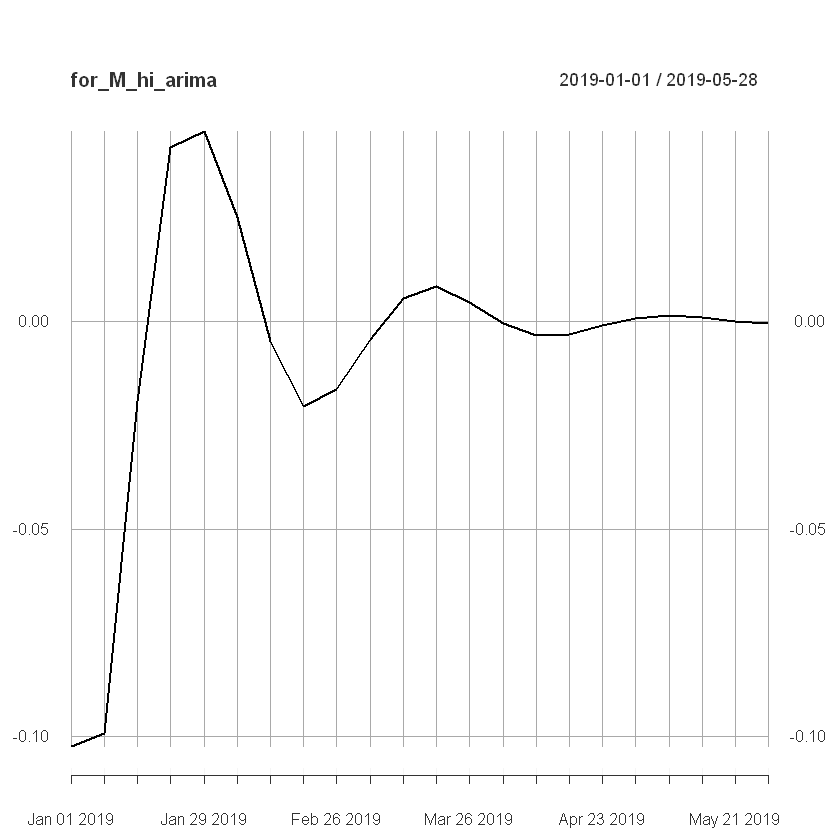

In [158]:
#Forecasting residuals (errors) and trnsform to xts object
for_M_hi_arima <- forecast(M_hi_Arima, h = 22)
dates_valid <- seq(as.Date("2019-01-01"), length = 22, by = "weeks")
for_M_hi_arima <- xts(for_M_hi_arima$mean, order.by = dates_valid)

head(for_M_hi_arima)
plot(for_M_hi_arima)

In [159]:
#Time series model for demand itself
M_hi_model_arima <- auto.arima(M_hi)

for_M_hi <- forecast(M_hi_model_arima, 22)
for_M_hi_xts <- xts(for_M_hi$mean, order.by = for_dates)
M_hi_v <- M_hi[index(M_hi) >= "2019-01-01"]

MAPE <- 100 * mean(abs((for_M_hi_xts - M_hi_v)/M_hi_v))
print(MAPE)

[1] 14.71265


In [160]:
# Ensembling ARIMA Time Series and Regression

pred_M_hi_xts <- xts(pred_M_hi, order.by=dates)
for_M_hi_en <- 0.5 * (for_M_hi_xts + pred_M_hi_xts)

MAPE <- 100 * mean(abs((for_M_hi_en - M_hi_v)/M_hi_v))
print(MAPE)

names(for_M_hi_en) <- "for_M_hi_en"
# A better result with the Ensemble Forecast!

[1] 13.84405


In [161]:
# Transform to data frame with 22 date points
dates <- data.frame(date=index(for_M_hi_en))
for_M_hi_en <- as.vector(for_M_hi_en)
M_hi_v <- as.vector(M_hi_v)

df <- data.frame(dates,for_M_hi_en, M_hi_v)
colnames(df) <- c("dates", "for_M_hi_en", "M_hi_v")
head(df)

dates,for_M_hi_en,M_hi_v
2019-01-01,430.0555,507
2019-01-08,433.0485,587
2019-01-15,422.5812,453
2019-01-22,451.7307,493
2019-01-29,454.6804,467
2019-02-05,459.1798,377


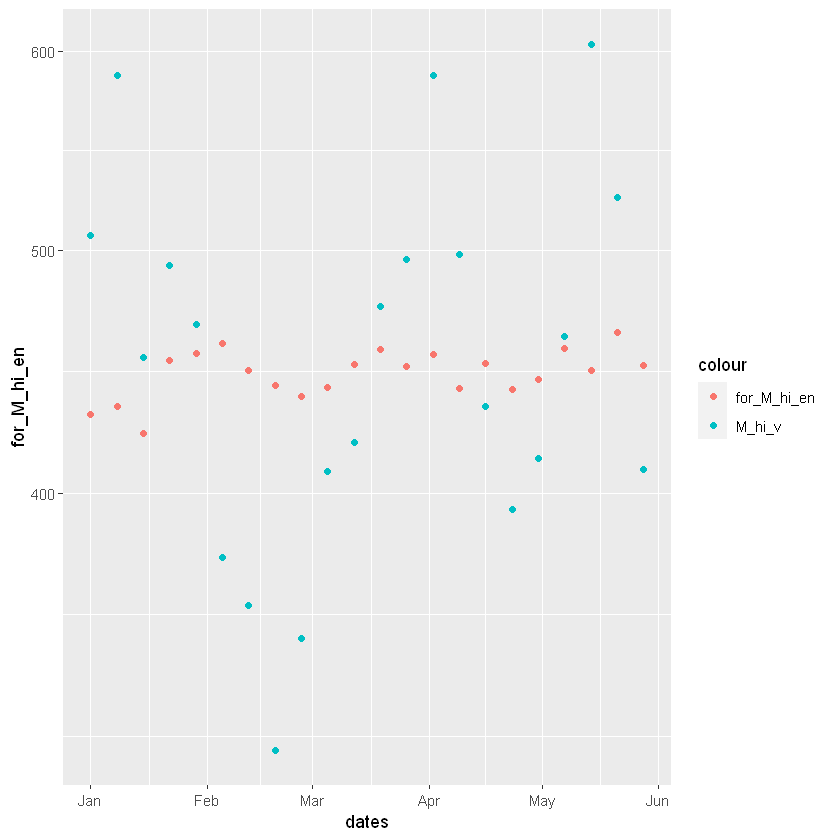

In [162]:
# Plot of actual values vs forecast
library(ggplot2)

ggplot(df, aes(dates)) + 
  geom_point(aes(y = for_M_hi_en, colour = "for_M_hi_en")) + 
  geom_point(aes(y = M_hi_v, colour = "M_hi_v")) + scale_y_log10()